# chl Forecasting with Time Series Models

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import xgboost as xgb

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Input, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load the data
file_path = "data_2018_2023_chl_sst_sswh_clean.csv"
df = pd.read_csv(file_path)

# Converting 'time' column to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Grouping data by month
df_chl = df['chl'].resample('ME').mean()  
df_sswh = df['VCMX'].resample('ME').mean()  
df_sst = df['analysed_sst'].resample('ME').mean()
df_nppv = df['nppv'].resample('ME').mean()
df_phyc = df['phyc'].resample('ME').mean()
df_nh4 = df['nh4'].resample('ME').mean()
df_fe = df['fe'].resample('ME').mean()

In [2]:
df.dtypes

VHM0                float64
VTM02               float64
VTM10               float64
VMDR                float64
VPED                float64
VTPK                float64
VCMX                float64
VMXL                float64
VHM0_WW             float64
VHM0_SW1            float64
VHM0_SW2            float64
VMDR_WW             float64
VMDR_SW1            float64
VMDR_SW2            float64
VTM01_WW            float64
VTM01_SW1           float64
VTM01_SW2           float64
VSDX                float64
VSDY                float64
analysed_sst        float64
analysis_error      float64
mask                float64
sea_ice_fraction    float64
longitude           float64
latitude            float64
depth               float64
po4                 float64
phyc                float64
si                  float64
nh4                 float64
chl                 float64
fe                  float64
no3                 float64
nppv                float64
zeu                 float64
o2                  

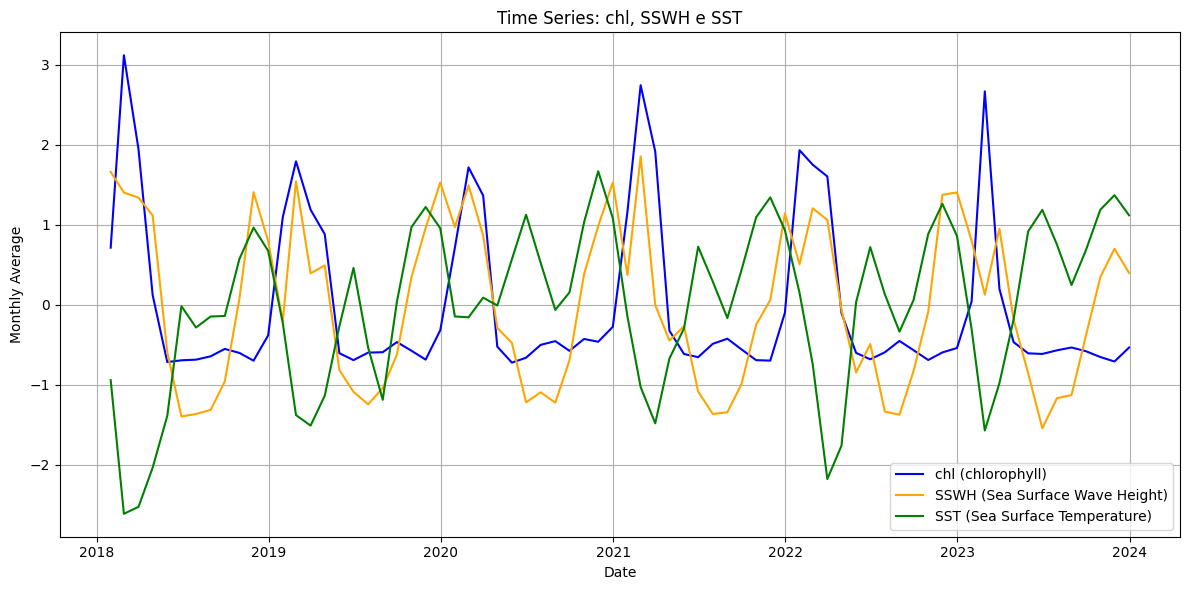

In [3]:
# Resample to monthly mean
monthly_df = df[['chl', 'VCMX', 'analysed_sst']].resample('ME').mean()

# Apply Z-score Standardization
scaler = StandardScaler()
smoothed_df = pd.DataFrame(scaler.fit_transform(monthly_df),
                               index=monthly_df.index,
                               columns=monthly_df.columns)
# Plot
plt.figure(figsize=(12, 6))
plt.plot(smoothed_df.index, smoothed_df['chl'], label='chl (chlorophyll)', color='blue')
plt.plot(smoothed_df.index, smoothed_df['VCMX'], label='SSWH (Sea Surface Wave Height)', color='orange')
plt.plot(smoothed_df.index, smoothed_df['analysed_sst'], label='SST (Sea Surface Temperature)', color='green')

plt.title('Time Series: chl, SSWH e SST')
plt.xlabel('Date')
plt.ylabel('Monthly Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Sea Surface Temperature**
- Tends to peak mid-year (summer) and drop sharply in winter (consistent with solar heating).

**CHL vs SST**
- Chlorophyll often peaks when SST drops — usually in late winter to spring. This inverse pattern may indicate phytoplankton blooms when waters are cooler and nutrient-rich (due to mixing/upwelling).

**CHL vs SSWH**
- Some alignment is visible: when SSWH (orange) rises, CHL also tends to increase. Suggests that higher wave energy may help mix nutrients, supporting phytoplankton growth.

# Check Stationarity

In [4]:
# https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries.dropna(), autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(df_chl)
check_stationarity(df_sswh)
check_stationarity(df_sst)

ADF Statistic: -0.6321456230753009
p-value: 0.8635517598445732
Non-Stationary
ADF Statistic: -2.26068474926724
p-value: 0.18496148745236118
Non-Stationary
ADF Statistic: -1.8681413359130776
p-value: 0.34719359878396566
Non-Stationary


In [5]:
# Applying differentiation to make stationary
df_chl_diff = df_chl.diff().dropna()
df_sswh_diff = df_sswh.diff().dropna()
df_sst_diff = df_sst.diff().dropna()

# Recheck stationarity
p_value_diff_chl = check_stationarity(df_chl_diff)
p_value_diff_sswh = check_stationarity(df_sswh_diff)
p_value_diff_sst = check_stationarity(df_sst_diff)

ADF Statistic: -4.010765300788443
p-value: 0.00135517825031707
Stationary
ADF Statistic: -7.2999007692833064
p-value: 1.3471661466692326e-10
Stationary
ADF Statistic: -7.039319437574289
p-value: 5.902834924170137e-10
Stationary


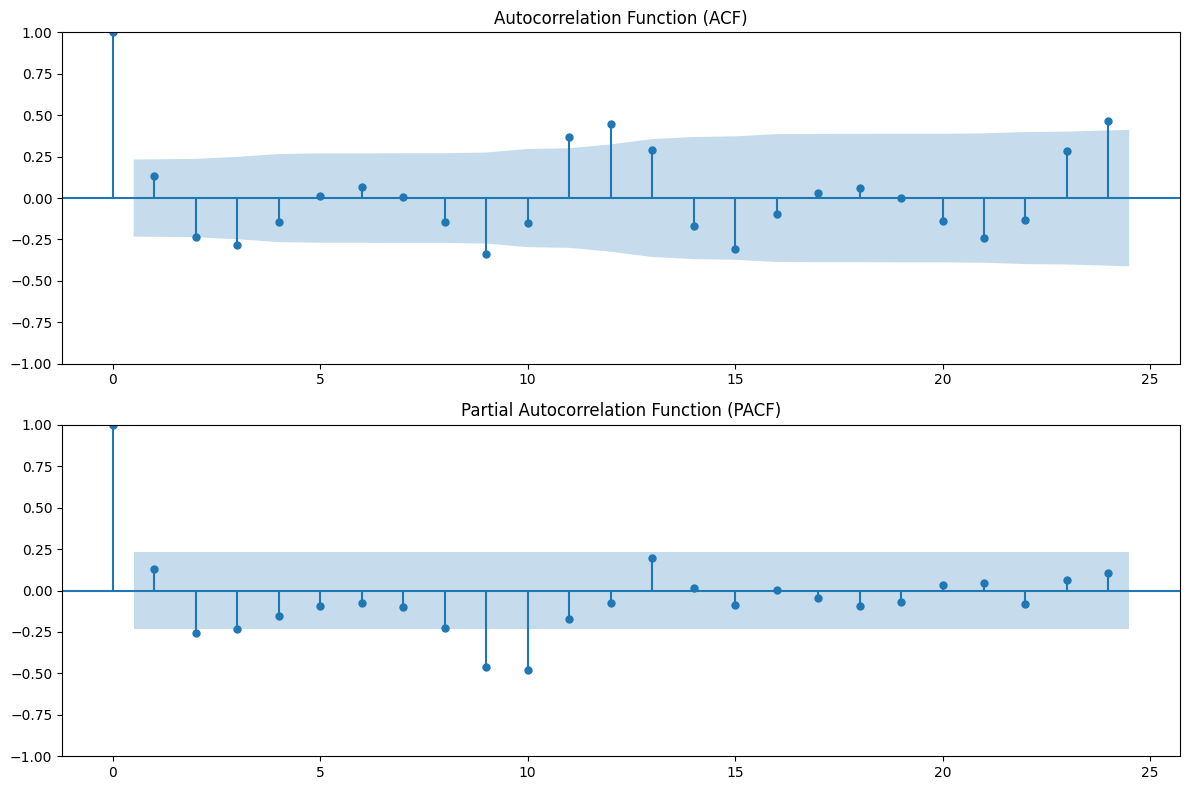

In [6]:
# Plot ACF and PACF graphs to determine p and q
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation (ACF) to identify q
plot_acf(df_chl_diff.dropna(), ax=ax[0], lags=24)
ax[0].set_title("Autocorrelation Function (ACF)")

# Partial Autocorrelation (PACF) to identify p
plot_pacf(df_chl_diff.dropna(), ax=ax[1], lags=24, method="ywm")
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

**ACF plot**

A spike at lag 12 is significant, which indicates seasonality of 12 months. A moderate spike at lag 24 is weaker, but still noticeable.
Q=1.

**PACF plot**

A spike at lag 12 is visible too, which indicates a seasonal AR component. Other lags show little significant structure beyond lag 12.
P=1.

In [7]:
# Fix ValueError: could not convert string to float: '2022-02-01'
df = df.reset_index(drop=True)

In [8]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df)
# scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
# print(scaled_df.head())

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Apply StandardScaler only to numeric columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

# Create a new DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)

# Add back non-numeric columns (like 'time')
scaled_df = pd.concat([scaled_df, df.drop(columns=numeric_cols)], axis=1)

## Separate data in training and test (80% training, 20% test)

In [9]:
train_size = int(len(df_chl) * 0.8)
train, test = df_chl[:train_size], df_chl[train_size:]

# Linear Regression

MSE Linear Regression: 0.0007754802201808432
RMSE Linear Regression: 0.027847445487527992
MAE Linear Regression: 0.019267826036718637
R2 Linear Regression: -0.013025799046264108


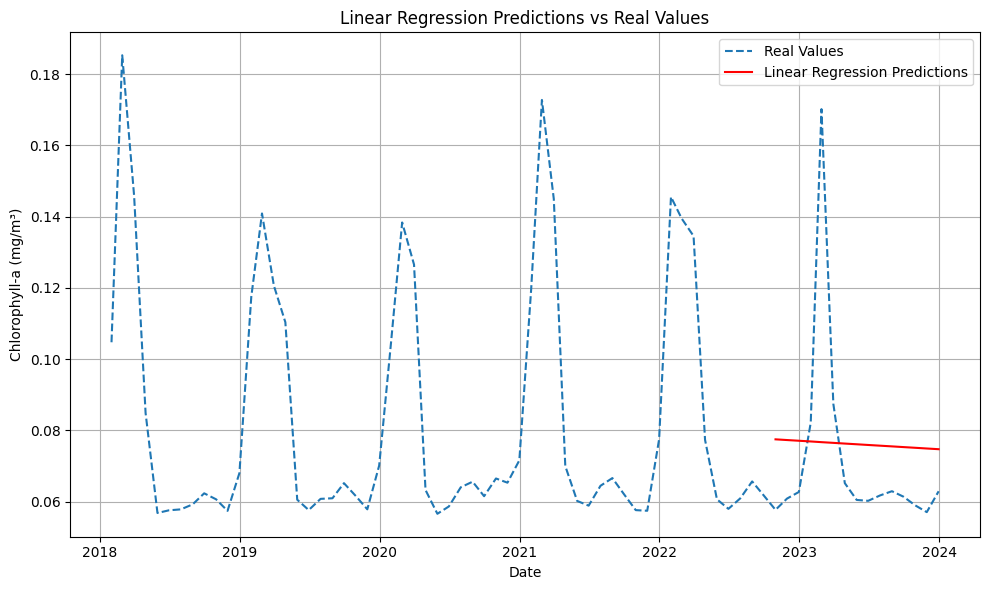

In [10]:
# Preparing data for Linear Regression model
X_train_lr = np.arange(len(train)).reshape(-1, 1)
y_train_lr = train.values

X_test_lr = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_test_lr = test.values

# Create and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Forecasting with Linear Regression
lr_predictions = lr_model.predict(X_test_lr)

# Calculating MSE, RMSE, MAE, and R2 for Linear Regression
mse_lr = mean_squared_error(y_test_lr, lr_predictions)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test_lr, lr_predictions)
r2_lr = r2_score(y_test_lr, lr_predictions)

print(f"MSE Linear Regression: {mse_lr}")
print(f"RMSE Linear Regression: {rmse_lr}")
print(f"MAE Linear Regression: {mae_lr}")
print(f"R2 Linear Regression: {r2_lr}")

# Create time index for full series
full_index = df_chl.index

# Create datetime index for predictions
prediction_index = full_index[len(train):len(train) + len(test)]

# Plot using datetime index
plt.figure(figsize=(10, 6))
plt.plot(full_index, df_chl.values, label='Real Values', linestyle='--')
plt.plot(prediction_index, lr_predictions, label='Linear Regression Predictions', color='red')

plt.title('Linear Regression Predictions vs Real Values')
plt.xlabel('Date')
plt.ylabel('Chlorophyll-a (mg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARIMA 

In [11]:
# p (Autoregressive Order):
# Indicates how many past observations of the time series itself are used to predict the current value. 
# For example, a p=1 means that the current value is influenced by the previous value.

# d (Differencing Order):
# Indicates how many times the time series needs to be differencing to become stationary. 
# A stationary series has a constant mean and variance over time, which is a necessary condition for ARIMA. 
# Differentiation involves calculating the difference between consecutive observations.

# q (Moving Average Order):
# Indicates how many past error forecasts are used to predict the current value. 
# For example, a q=1 means that the current value is influenced by the forecast error from the previous period.


# Define ranges for p, d, q
p_values = [0, 1, 2]    # order of the autoregressive (AR) component
d_values = [0, 1]       # order of differencing (to make the series stationary)
q_values = [0, 1, 2]    # how many past error forecasts are used to predict the current value

best_aic = float('inf')
best_order = None
results = []

# Test combinations of (p, d, q)
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(df_chl_diff, order=(p, d, q)).fit()
                # Save the results
                results.append({
                    'order': (p, d, q),
                    'AIC': model.aic,    # Akaike Information Criterion
                    'BIC': model.bic,    # Bayesian Information Criterion
                    'HQIC': model.hqic,  # Hannan–Quinn Information Criterion 
                    'Log-Likelihood': model.llf
                })
                # Check the best AIC. Used to select the best order of the model, that is, the parameters p, d, and q that describe the ARIMA model
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
            except Exception as e:
                print(f"Erro com a ordem (p,d,q)=({p},{d},{q}): {e}")

# Show results sorted by AIC
results = sorted(results, key=lambda x: x['AIC'])
print(f"\nBest order based on AIC: {best_order} com AIC = {best_aic:.2f}\n")

for res in results:
    print(f"ARIMA{res['order']} - AIC: {res['AIC']:.2f}, BIC: {res['BIC']:.2f}, HQIC: {res['HQIC']:.2f}, Log-Likelihood: {res['Log-Likelihood']:.2f}")


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z


Best order based on AIC: (2, 0, 1) com AIC = -316.43

ARIMA(2, 0, 1) - AIC: -316.43, BIC: -305.12, HQIC: -311.93, Log-Likelihood: 163.21
ARIMA(2, 0, 2) - AIC: -310.88, BIC: -297.30, HQIC: -305.48, Log-Likelihood: 161.44
ARIMA(1, 0, 2) - AIC: -310.77, BIC: -299.46, HQIC: -306.27, Log-Likelihood: 160.39
ARIMA(0, 0, 2) - AIC: -307.29, BIC: -298.24, HQIC: -303.69, Log-Likelihood: 157.65
ARIMA(2, 0, 0) - AIC: -298.58, BIC: -289.53, HQIC: -294.98, Log-Likelihood: 153.29
ARIMA(0, 0, 1) - AIC: -295.66, BIC: -288.88, HQIC: -292.97, Log-Likelihood: 150.83
ARIMA(0, 0, 0) - AIC: -295.22, BIC: -290.69, HQIC: -293.42, Log-Likelihood: 149.61
ARIMA(1, 0, 0) - AIC: -294.58, BIC: -287.79, HQIC: -291.88, Log-Likelihood: 150.29
ARIMA(1, 0, 1) - AIC: -294.21, BIC: -285.16, HQIC: -290.61, Log-Likelihood: 151.10
ARIMA(2, 1, 1) - AIC: -288.57, BIC: -279.58, HQIC: -285.00, Log-Likelihood: 148.29
ARIMA(0, 1, 2) - AIC: -286.46, BIC: -279.71, HQIC: -283.78, Log-Likelihood: 146.23
ARIMA(0, 1, 1) - AIC: -285.66, B

C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# Fit the ARIMA(2, 0, 1) model
best_model = ARIMA(df_chl_diff, order=(2, 0, 1)).fit()

# Making predictions with the ARIMA(2, 0, 1) model
forecast_steps = 12
forecast = best_model.get_forecast(steps=forecast_steps)

# Set the index for forecasts
forecast_index = pd.date_range(start=df_chl.index[-1], periods=forecast_steps + 1, freq='MS')[1:]
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Convert confidence intervals to numpy arrays
lower_ci = np.array(forecast_ci.iloc[:, 0], dtype=np.float64)
upper_ci = np.array(forecast_ci.iloc[:, 1], dtype=np.float64)

y_test = test[:forecast_steps]

# Calculate MSE, RMSE, MAE, and R²
mse = mean_squared_error(y_test, forecast_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast_mean)
r2 = r2_score(y_test, forecast_mean)

print(f"ARIMA MSE (Mean Squared Error): {mse:.4f}")
print(f"ARIMA RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"ARIMA MAE (Mean Absolute Error): {mae:.4f}")
print(f"ARIMA R² (R-Squared): {r2:.4f}")

C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA MSE (Mean Squared Error): 0.0065
ARIMA RMSE (Root Mean Squared Error): 0.0804
ARIMA MAE (Mean Absolute Error): 0.0740
ARIMA R² (R-Squared): -6.0827


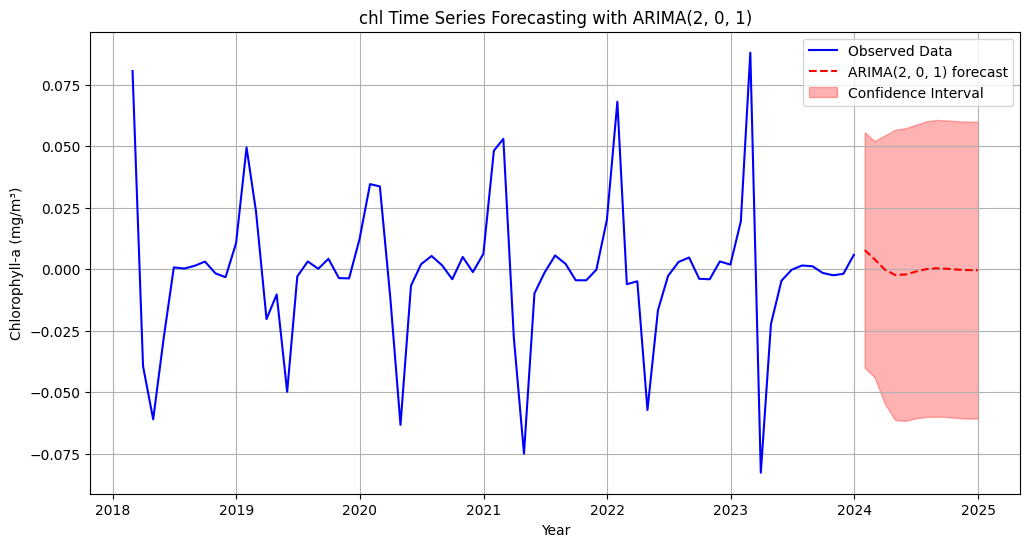


ARIMA(2, 0, 1) Model Predictions:
            chl Prediction  Lower Limit  Upper Limit
Date                                                
2024-02-01        0.007794    -0.040079     0.055667
2024-03-01        0.004106    -0.043852     0.052065
2024-04-01       -0.000207    -0.054800     0.054387
2024-05-01       -0.002335    -0.061338     0.056668
2024-06-01       -0.002163    -0.061658     0.057332
2024-07-01       -0.000964    -0.060593     0.058665
2024-08-01        0.000046    -0.060039     0.060131
2024-09-01        0.000379    -0.059896     0.060654
2024-10-01        0.000189    -0.060091     0.060469
2024-11-01       -0.000148    -0.060451     0.060155
2024-12-01       -0.000362    -0.060694     0.059970
2025-01-01       -0.000393    -0.060731     0.059946


In [13]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df_chl_diff, label='Observed Data', color='blue')
plt.plot(forecast_index, forecast_mean, label='ARIMA(2, 0, 1) forecast', color='red', linestyle='--')
plt.fill_between(forecast_index, lower_ci, upper_ci, color='red', alpha=0.3, label='Confidence Interval')
plt.title('chl Time Series Forecasting with ARIMA(2, 0, 1)')
plt.xlabel('Year')
plt.ylabel('Chlorophyll-a (mg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Display predictions as DataFrame
forecast_df = forecast_mean.to_frame(name='chl Prediction')
forecast_df.index = forecast_index  # Adjust the index for target dates
forecast_df.index.name = 'Date'

# Add confidence intervals to the DataFrame
forecast_df['Lower Limit'] = lower_ci
forecast_df['Upper Limit'] = upper_ci

print("\nARIMA(2, 0, 1) Model Predictions:")
print(forecast_df)

It's missing the Sazonality factor -> SARIMA

# SARIMA

In [14]:
# Define SARIMA parameters
p, d, q = 2, 0, 1
P, D, Q, s = 1, 0, 1, 12  # Monthly seasonality

# Fit the SARIMA model
model = SARIMAX(df_chl_diff, order=(p, d, q), seasonal_order=(P, D, Q, s)) # SARIMAX without exogenous variables
results = model.fit()
model

C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA MSE (Mean Squared Error): 0.0067
SARIMA RMSE (Root Mean Squared Error): 0.0817
SARIMA MAE (Mean Absolute Error): 0.0677
SARIMA R² (R-Squared): -7.7243


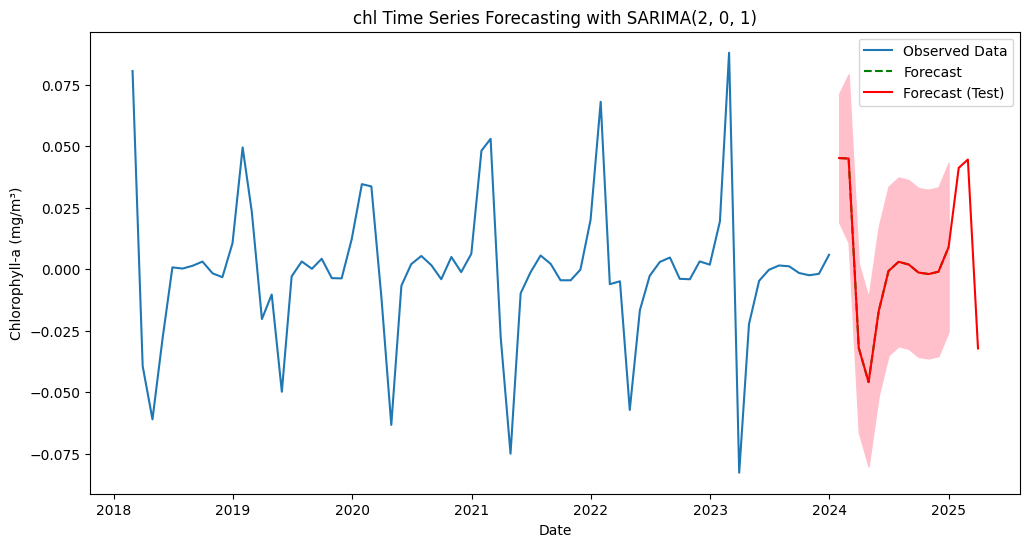

In [15]:
# Predictions for the test period
sarima_predictions = results.get_forecast(steps=len(test))
sarima_pred_mean = sarima_predictions.predicted_mean
sarima_pred_ci = sarima_predictions.conf_int()

# Forecasting future values
sarima_forecast_periods = 12  # Forecast the next 12 months
sarima_forecast = results.get_forecast(steps=sarima_forecast_periods)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_ci = sarima_forecast.conf_int()

y_test = test[:len(sarima_pred_mean)]

# Calculate MSE, RMSE, MAE e R²
mse_sarima = mean_squared_error(y_test, sarima_pred_mean)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(y_test, sarima_pred_mean)
r2_sarima = r2_score(y_test, sarima_pred_mean)

print(f"SARIMA MSE (Mean Squared Error): {mse_sarima:.4f}")
print(f"SARIMA RMSE (Root Mean Squared Error): {rmse_sarima:.4f}")
print(f"SARIMA MAE (Mean Absolute Error): {mae_sarima:.4f}")
print(f"SARIMA R² (R-Squared): {r2_sarima:.4f}")

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_chl_diff, label='Observed Data')
plt.plot(sarima_forecast_mean, label='Forecast', color='green', linestyle="dashed")
plt.plot(sarima_pred_mean, label='Forecast (Test)', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='pink')
plt.title("chl Forecast")
plt.title('chl Time Series Forecasting with SARIMA(2, 0, 1)')

plt.xlabel("Date")
plt.ylabel("Chlorophyll-a (mg/m³)")
plt.legend()
plt.show()

# SARIMAX

C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX MSE (Mean Squared Error): 0.0067
SARIMAX RMSE (Root Mean Squared Error): 0.0817
SARIMAX MAE (Mean Absolute Error): 0.0677
SARIMAX R² (R-Squared): -7.7243


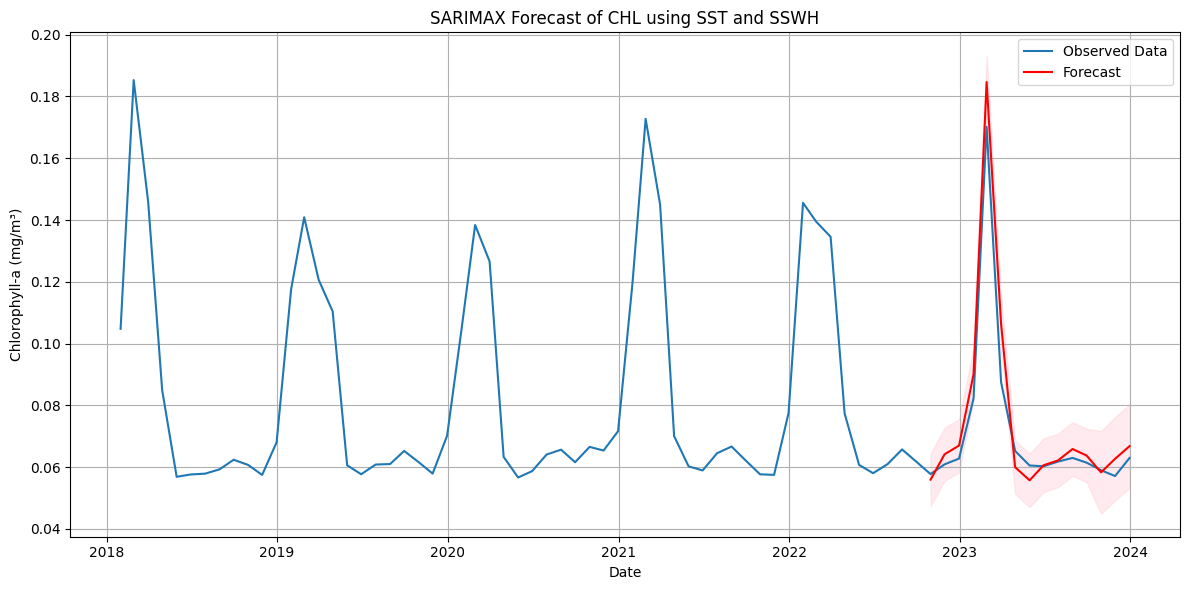

In [16]:
# Combining SSWH and SST into one DataFrame (exog_vars) and
# align them with the endogenous variable (chl)

exog_vars = pd.concat([df_sswh, df_sst, df_nppv, df_phyc, df_nh4, df_fe], axis=1).dropna()
exog_vars.columns = ['sswh', 'sst', 'nppv', 'phyc', 'nh4', 'fe']
chl_series = df_chl.loc[exog_vars.index]

# Final aligned datasets
chl_final = chl_series
exog_final = exog_vars

# Train/test split
train_size = int(len(chl_final) * 0.8)
chl_train, chl_test = chl_final[:train_size], chl_final[train_size:]
exog_train, exog_test = exog_final[:train_size], exog_final[train_size:]

# Fit SARIMAX model with seasonal components
model = SARIMAX(
    chl_train,
    exog=exog_train,
    order=(2, 0, 1),              # ARIMA component
    seasonal_order=(1, 1, 1, 12)  # Seasonal component: (P, D, Q, S)
)
model_fit = model.fit(disp=False)

# Forecast
forecast_result = model_fit.get_forecast(steps=len(chl_test), exog=exog_test)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Calculate MSE, RMSE, MAE, R²
mse_sarimax = mean_squared_error(chl_test, sarima_pred_mean)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(chl_test, sarima_pred_mean)
r2_sarimax = r2_score(chl_test, sarima_pred_mean)

print(f"SARIMAX MSE (Mean Squared Error): {mse_sarimax:.4f}")
print(f"SARIMAX RMSE (Root Mean Squared Error): {rmse_sarimax:.4f}")
print(f"SARIMAX MAE (Mean Absolute Error): {mae_sarimax:.4f}")
print(f"SARIMAX R² (R-Squared): {r2_sarimax:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(chl_final, label='Observed Data')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast of CHL using SST and SSWH')
plt.xlabel('Date')
plt.ylabel('Chlorophyll-a (mg/m³)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
LSTM MSE (Mean Squared Error): 0.0005
LSTM RMSE (Root Mean Squared Error): 0.0222
LSTM MAE (Mean Absolute Error): 0.0190
LSTM R² (R-Squared): -6.3811


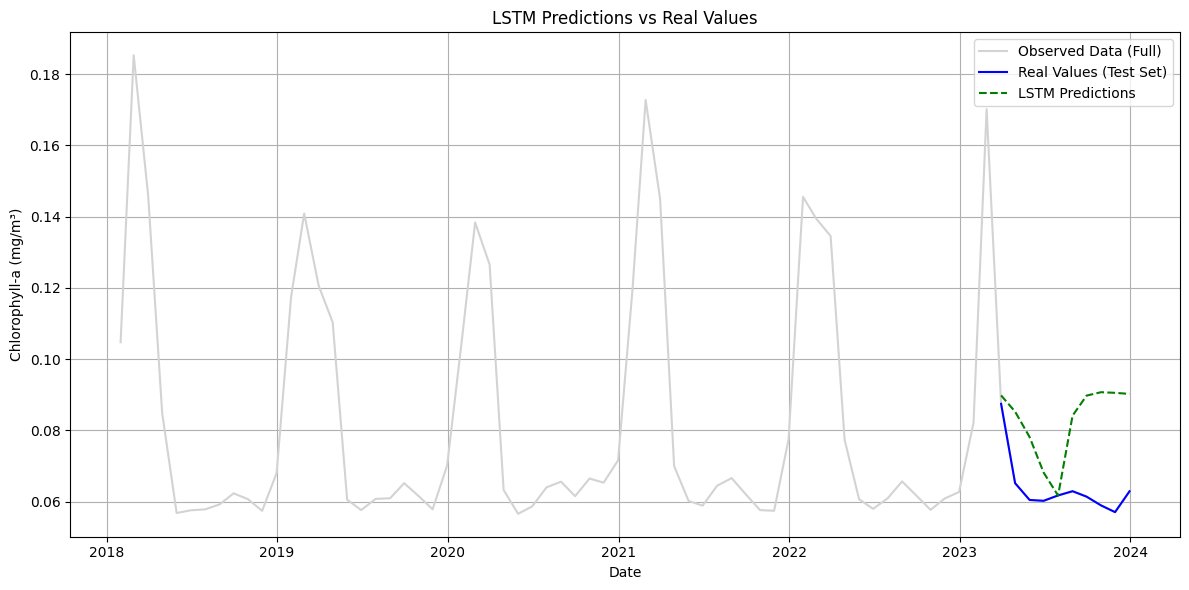

In [17]:
# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Function to create sequences with seq_length set to 5
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Adjust seq_length
seq_length = 5
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Construction of the LSTM model with the best configuration found
lstm_model = Sequential([
    Input(shape=(seq_length, 1)),
    LSTM(60, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.0001)), Dropout(0.2),
    LSTM(60, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.0001)), Dropout(0.2),
    LSTM(30, activation='tanh', kernel_regularizer=l2(0.0001)), Dropout(0.2), Dense(1)
])
# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Early Stopping
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

# Model Training
lstm_model.fit(X_train, y_train, epochs=250, batch_size=8, verbose=0, callbacks=[early_stopping])

# Predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Undo normalization for actual test values
actual_values = scaler.inverse_transform(test_scaled[seq_length:])

# Evaluation metrics
mse_lstm = mean_squared_error(actual_values, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(actual_values, lstm_predictions)
r2_lstm = r2_score(actual_values, lstm_predictions)

print(f"LSTM MSE (Mean Squared Error): {mse_lstm:.4f}")
print(f"LSTM RMSE (Root Mean Squared Error): {rmse_lstm:.4f}")
print(f"LSTM MAE (Mean Absolute Error): {mae_lstm:.4f}")
print(f"LSTM R² (R-Squared): {r2_lstm:.4f}")

# Get the date index for predictions
start_idx = df_chl.index.get_loc(test.index[0]) + seq_length
end_idx = start_idx + len(lstm_predictions)
date_index = df_chl.index[start_idx:end_idx]

# Plot full time series for context
plt.figure(figsize=(12, 6))

# Plot full observed chlorophyll data (2018 onward)
plt.plot(df_chl.index, df_chl.values, label='Observed Data (Full)', color='lightgray')

# Plot actual values in test set
plt.plot(date_index, actual_values, label='Real Values (Test Set)', color='blue')

# Plot predictions
plt.plot(date_index, lstm_predictions, label='LSTM Predictions', color='green', linestyle='dashed')

# Final plot config
plt.title('LSTM Predictions vs Real Values')
plt.xlabel('Date')
plt.ylabel('Chlorophyll-a (mg/m³)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [18]:
# # Normalize data for LSTM
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
# test_scaled = scaler.transform(test.values.reshape(-1, 1))

# # Function to create sequences
# def create_sequences(data, seq_length):
#     sequences, labels = [], []
#     for i in range(len(data) - seq_length):
#         sequences.append(data[i:i+seq_length])
#         labels.append(data[i+seq_length])
#     return np.array(sequences), np.array(labels)

# seq_length = 5
# X_train, y_train = create_sequences(train_scaled, seq_length)
# X_test, y_test = create_sequences(test_scaled, seq_length)

# # Hiperparameters for Grid Search
# neurons = [60, 120, 150]
# dropouts = [0.1, 0.2, 0.3]
# learning_rates = [0.0001, 0.0003, 0.0005]
# l2_regs = [0, 0.0001, 0.001]

# # Variables to store the best results
# best_rmse = float('inf')
# best_params = None

# # Manual Grid Search
# for n, d, lr, l2_reg in itertools.product(neurons, dropouts, learning_rates, l2_regs):
#     # Construction of LSTM model with varying parameters
#     model = Sequential([
#         Input(shape=(seq_length, 1)),
#         LSTM(n, activation='tanh', return_sequences=True, kernel_regularizer=l2(l2_reg)),
#         Dropout(d),
#         LSTM(n, activation='tanh', return_sequences=True, kernel_regularizer=l2(l2_reg)),
#         Dropout(d),
#         LSTM(n // 2, activation='tanh', kernel_regularizer=l2(l2_reg)),
#         Dropout(d),
#         Dense(1)
#     ])
    
#     model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

#     # Early Stopping to avoid overfitting
#     early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

#     # Model Training
#     model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0, callbacks=[early_stopping])

#     # Predictions with the model
#     predictions = model.predict(X_test)
#     predictions = scaler.inverse_transform(predictions)
#     rmse = np.sqrt(mean_squared_error(test[seq_length:], predictions))

#     # Save the best parameters
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = {'neurons': n, 'dropout': d, 'learning_rate': lr, 'l2_reg': l2_reg}

#     print(f"Tested: Neurons={n}, Dropout={d}, Learning Rate={lr}, L2 Reg={l2_reg} => RMSE: {rmse}")

# print(f"\nBest configuration found: {best_params} with RMSE: {best_rmse}")

# # Prepare real data for plotting
# actual_values = scaler.inverse_transform(test_scaled[seq_length:])

# # Plot predictions with best configuration
# plt.figure(figsize=(12, 6))
# plt.plot(actual_values, label='Real Values', color='blue')
# plt.plot(predictions, label='LSTM Predictions', color='green', linestyle='dashed')
# plt.title('LSTM Predictions vs Real Values')
# plt.xlabel('Time')
# plt.ylabel('Values')
# plt.legend()
# plt.grid()
# plt.show()

Commented to speed up cell execution

Best configuration found: {'neurons': 60, 'dropout': 0.2, 'learning_rate': 0.0001, 'l2_reg': 0.0001} with RMSE: 0.02024897360422989

# GRU (Gated Recurrent Unit)

C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
GRU MSE (Mean Squared Error): 0.0015
GRU RMSE (Root Mean Squared Error): 0.0384
GRU MAE (Mean Absolute Error): 0.0227
GRU R² (R-Squared): -21.1880


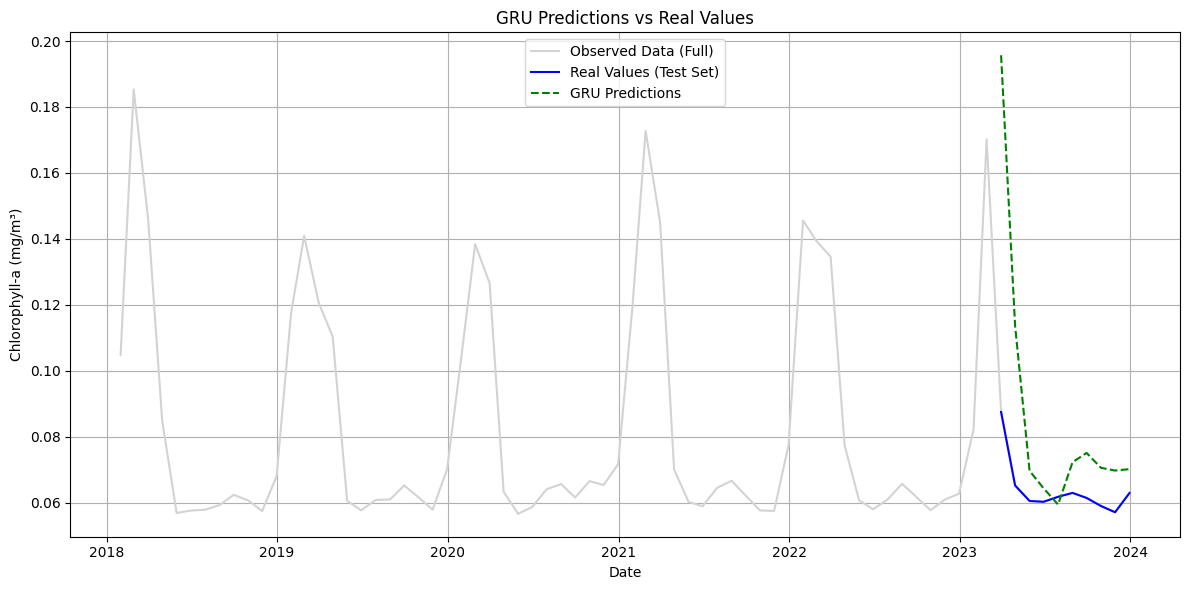

In [19]:
# Normalize data for GRU
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Adjust sequence length
seq_length = 5
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Build GRU model with specified configuration
improved_gru_model = Sequential([
    GRU(150, activation='tanh', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l2(0.00005)),
    Dropout(0.15),
    GRU(150, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.00005)),
    Dropout(0.15),
    GRU(75, activation='tanh', kernel_regularizer=l2(0.00005)),
    Dropout(0.15),
    Dense(1)
])

# Compile model
improved_gru_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Early stopping
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

# Train model
improved_gru_model.fit(X_train, y_train, epochs=250, batch_size=2, verbose=0, callbacks=[early_stopping])

# Make predictions
improved_gru_predictions = improved_gru_model.predict(X_test)
improved_gru_predictions = scaler.inverse_transform(improved_gru_predictions)

# Undo normalization for actual test values
actual_values = scaler.inverse_transform(test_scaled[seq_length:])

# Evaluation metrics
mse_gru = mean_squared_error(actual_values, improved_gru_predictions)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(actual_values, improved_gru_predictions)
r2_gru = r2_score(actual_values, improved_gru_predictions)

print(f"GRU MSE (Mean Squared Error): {mse_gru:.4f}")
print(f"GRU RMSE (Root Mean Squared Error): {rmse_gru:.4f}")
print(f"GRU MAE (Mean Absolute Error): {mae_gru:.4f}")
print(f"GRU R² (R-Squared): {r2_gru:.4f}")

# Determine date range for predictions
start_idx = df_chl.index.get_loc(test.index[0]) + seq_length
end_idx = start_idx + len(improved_gru_predictions)
date_index = df_chl.index[start_idx:end_idx]

# Plot full context with predictions
plt.figure(figsize=(12, 6))

# Plot full historical data
plt.plot(df_chl.index, df_chl.values, label='Observed Data (Full)', color='lightgray')

# Plot test set actual values
plt.plot(date_index, actual_values, label='Real Values (Test Set)', color='blue')

# Plot GRU predictions
plt.plot(date_index, improved_gru_predictions, label='GRU Predictions', color='green', linestyle='dashed')

# Final plot formatting
plt.title('GRU Predictions vs Real Values')
plt.xlabel('Date')
plt.ylabel('Chlorophyll-a (mg/m³)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Random Forest Regressor

In [20]:
# Define the hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900],
    'max_depth': [10, 20, 30, 40, 50, 60, 70],
    'min_samples_split': [2, 5, 10, 15, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Reshape to 2D
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], -1))

# Create the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Configure Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

(52, 5, 1)


C:\Python312\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


Best Hyperparameters: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


RF Regressor MSE (Mean Squared Error): 0.0003
RF Regressor RMSE (Root Mean Squared Error): 0.0181
RF Regressor MAE (Mean Absolute Error): 0.0110
RF Regressor R² (R-Squared): 0.5940


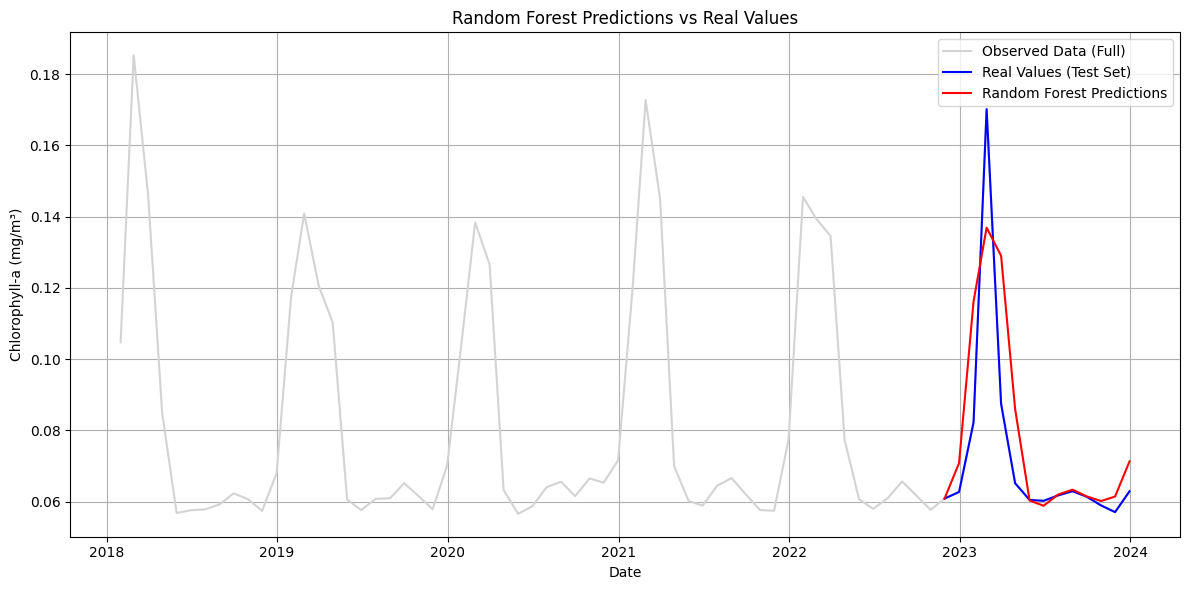

In [21]:
# Prepare data for Random Forest
df_rf = df_chl.to_frame()
df_rf['chl_lag1'] = df_rf['chl'].shift(1)
df_rf['chl_lag2'] = df_rf['chl'].shift(2)
df_rf['chl_lag3'] = df_rf['chl'].shift(3)
df_rf['chl_lag4'] = df_rf['chl'].shift(4)
df_rf['chl_lag5'] = df_rf['chl'].shift(5)
df_rf['chl_lag6'] = df_rf['chl'].shift(6)
df_rf['month'] = df_rf.index.month
df_rf = df_rf.dropna()

# Define features and target
features = ['chl_lag1', 'chl_lag2', 'chl_lag3', 'chl_lag4', 'chl_lag5', 'chl_lag6', 'month']
target = 'chl'

# Split dataset into train/test
train_size = int(len(df_rf) * 0.8)
train_rf = df_rf[:train_size]
test_rf = df_rf[train_size:]

# X and y for training and testing
X_train = train_rf[features]
y_train = train_rf[target]
X_test = test_rf[features]
y_test = test_rf[target]

# Define and train the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=18,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    max_features=0.8,
    bootstrap=True
)
rf_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)

# Evaluation metrics
mse_rf = mean_squared_error(y_test, rf_predictions)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, rf_predictions)
r2_rf = r2_score(y_test, rf_predictions)

print(f"RF Regressor MSE (Mean Squared Error): {mse_rf:.4f}")
print(f"RF Regressor RMSE (Root Mean Squared Error): {rmse_rf:.4f}")
print(f"RF Regressor MAE (Mean Absolute Error): {mae_rf:.4f}")
print(f"RF Regressor R² (R-Squared): {r2_rf:.4f}")

# Plot full time series and prediction
plt.figure(figsize=(12, 6))

# Full historical chlorophyll values
plt.plot(df_chl.index, df_chl.values, label='Observed Data (Full)', color='lightgray')

# Actual values from the test set
plt.plot(y_test.index, y_test, label='Real Values (Test Set)', color='blue')

# Predictions from the model
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', color='red')

plt.title("Random Forest Predictions vs Real Values")
plt.xlabel("Date")
plt.ylabel("Chlorophyll-a (mg/m³)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# XGBoost

In [22]:
# Remove values outside [0, 1]
y_train = np.where(y_train > 1, 1, 0)
y_test = np.where(y_test > 1, 1, 0)

# Prepare the data
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

# Define Parameters
n = 50
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}

# Train Model
model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=n)

# Make Predictions
probs = model.predict(xgb_test)  # Probabilities
preds = (probs >= 0.5).astype(int)  # # Convert probabilities to binary labels

# Calculate MSE, RMSE, MAE, R² and Accuracy
mse_xgb = mean_squared_error(y_test, probs)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, probs)
r2_xgb = r2_score(y_test, probs)

print(f"XGBoost MSE (Mean Squared Error): {mse_xgb:.4f}")
print(f"XGBoost RMSE (Root Mean Squared Error): {rmse_xgb:.4f}")
print(f"XGBoost MAE (Mean Absolute Error): {mae_xgb:.4f}")
print(f"XGBoost R² (R-Squared): {r2_xgb:.4f}")

XGBoost MSE (Mean Squared Error): 0.0004
XGBoost RMSE (Root Mean Squared Error): 0.0189
XGBoost MAE (Mean Absolute Error): 0.0189
XGBoost R² (R-Squared): 0.0000


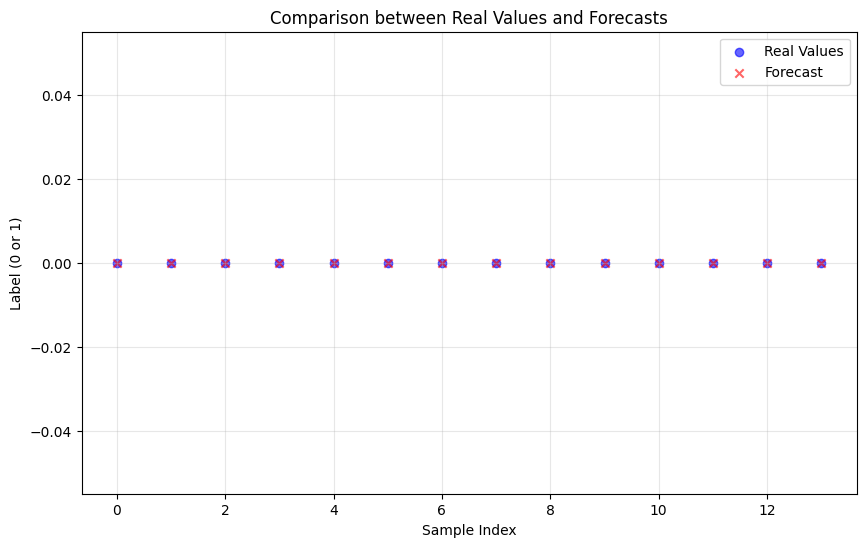

In [23]:
# Plot Results
plt.figure(figsize=(10, 6))

# Scatter plot to show predictions vs actual values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Real Values', alpha=0.6)
plt.scatter(range(len(preds)), preds, color='red', label='Forecast', alpha=0.6, marker='x')

# Chart Settings
plt.title('Comparison between Real Values and Forecasts')
plt.xlabel('Sample Index')
plt.ylabel('Label (0 or 1)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# CNN (Convolutional Neural Network)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Sequence Length: 10
CNN Mean Squared Error (MSE): 0.00
CNN Root Mean Squared Error (RMSE): 0.03
CNN Mean Absolute Error (MAE): 0.02
CNN R² (R-Squared): -0.04


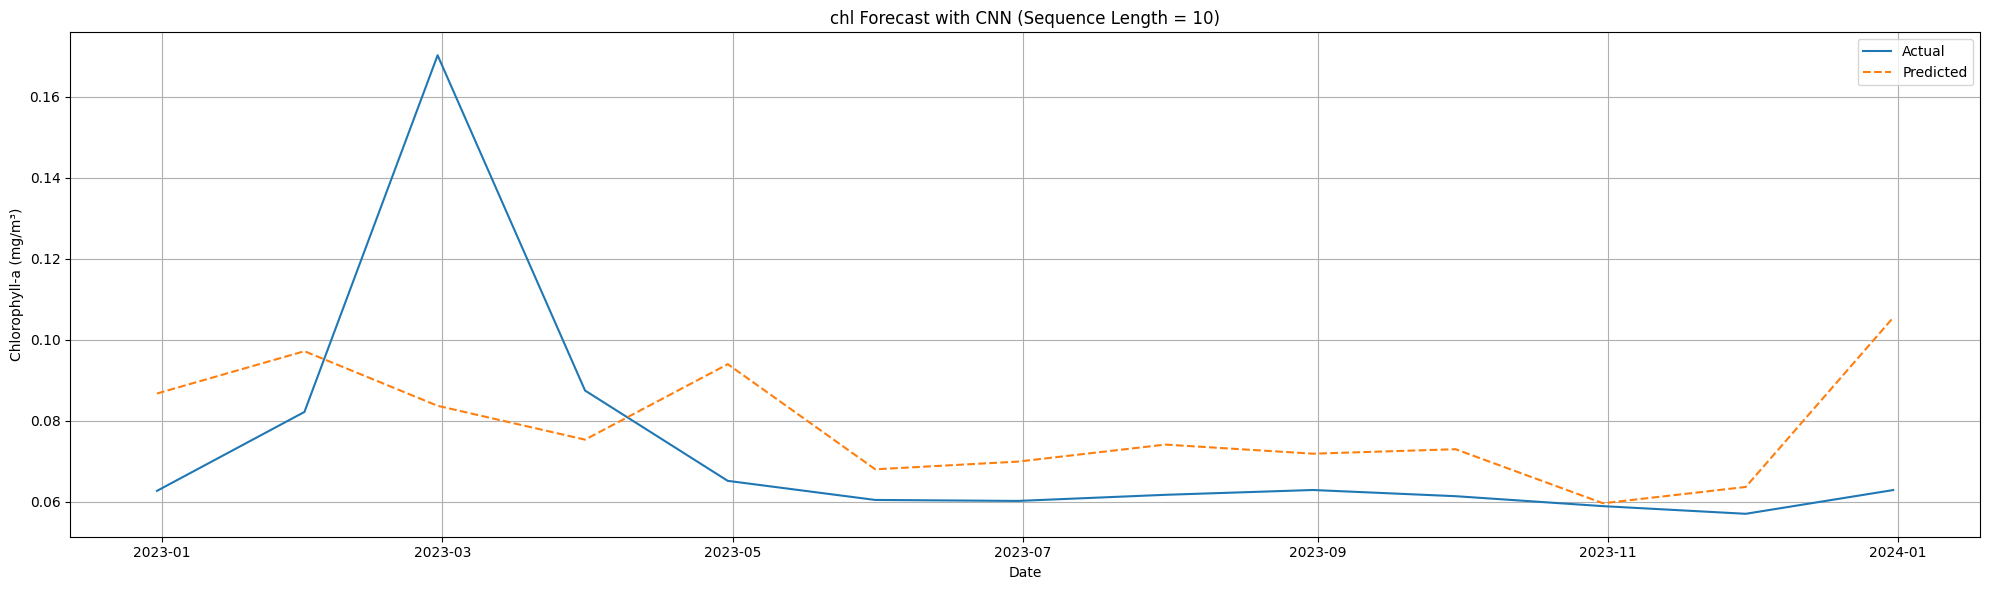

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Sequence Length: 20
CNN Mean Squared Error (MSE): 0.00
CNN Root Mean Squared Error (RMSE): 0.03
CNN Mean Absolute Error (MAE): 0.02
CNN R² (R-Squared): 0.32


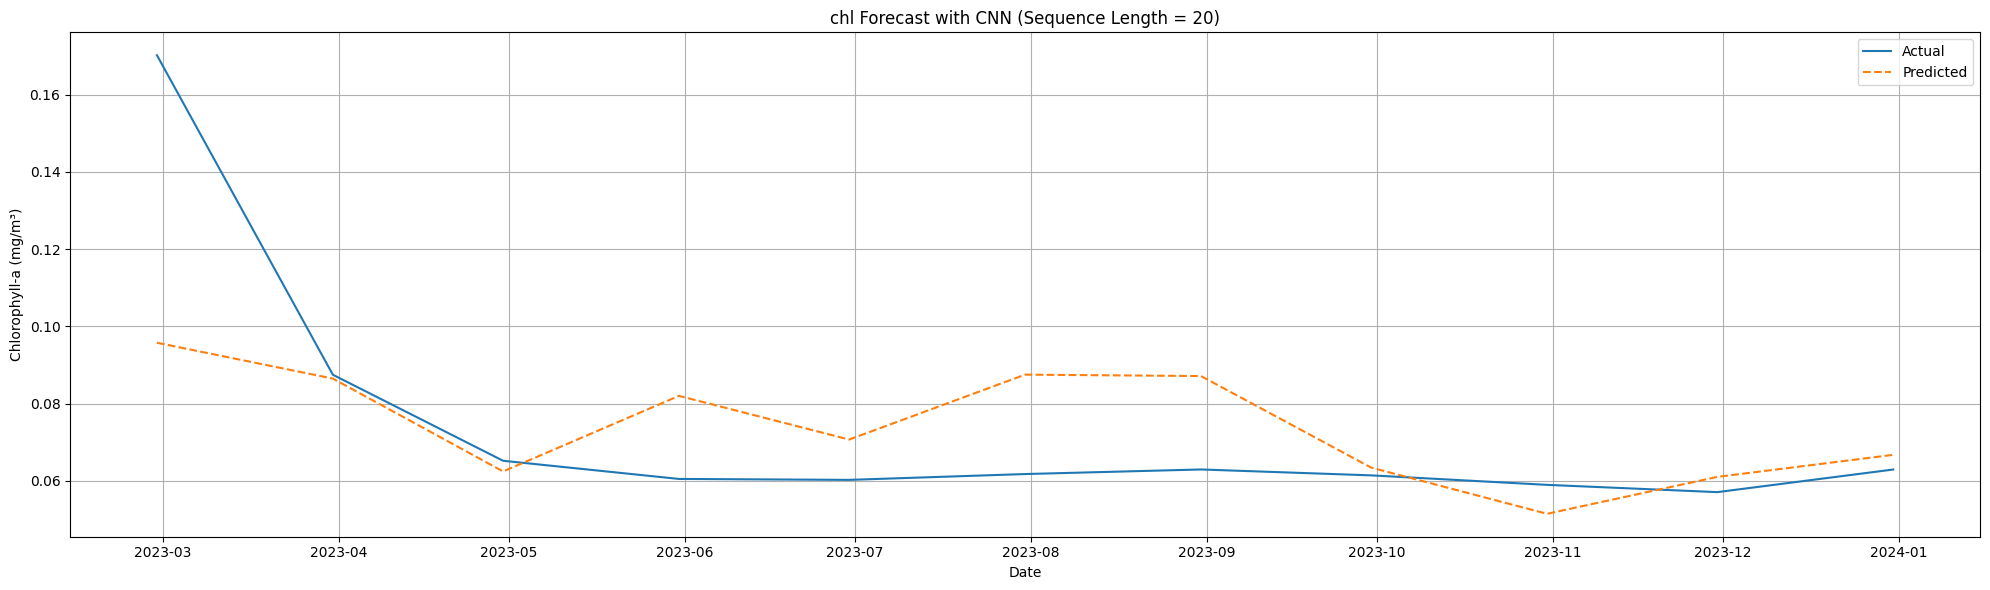

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Sequence Length: 30
CNN Mean Squared Error (MSE): 0.00
CNN Root Mean Squared Error (RMSE): 0.03
CNN Mean Absolute Error (MAE): 0.03
CNN R² (R-Squared): -172.78


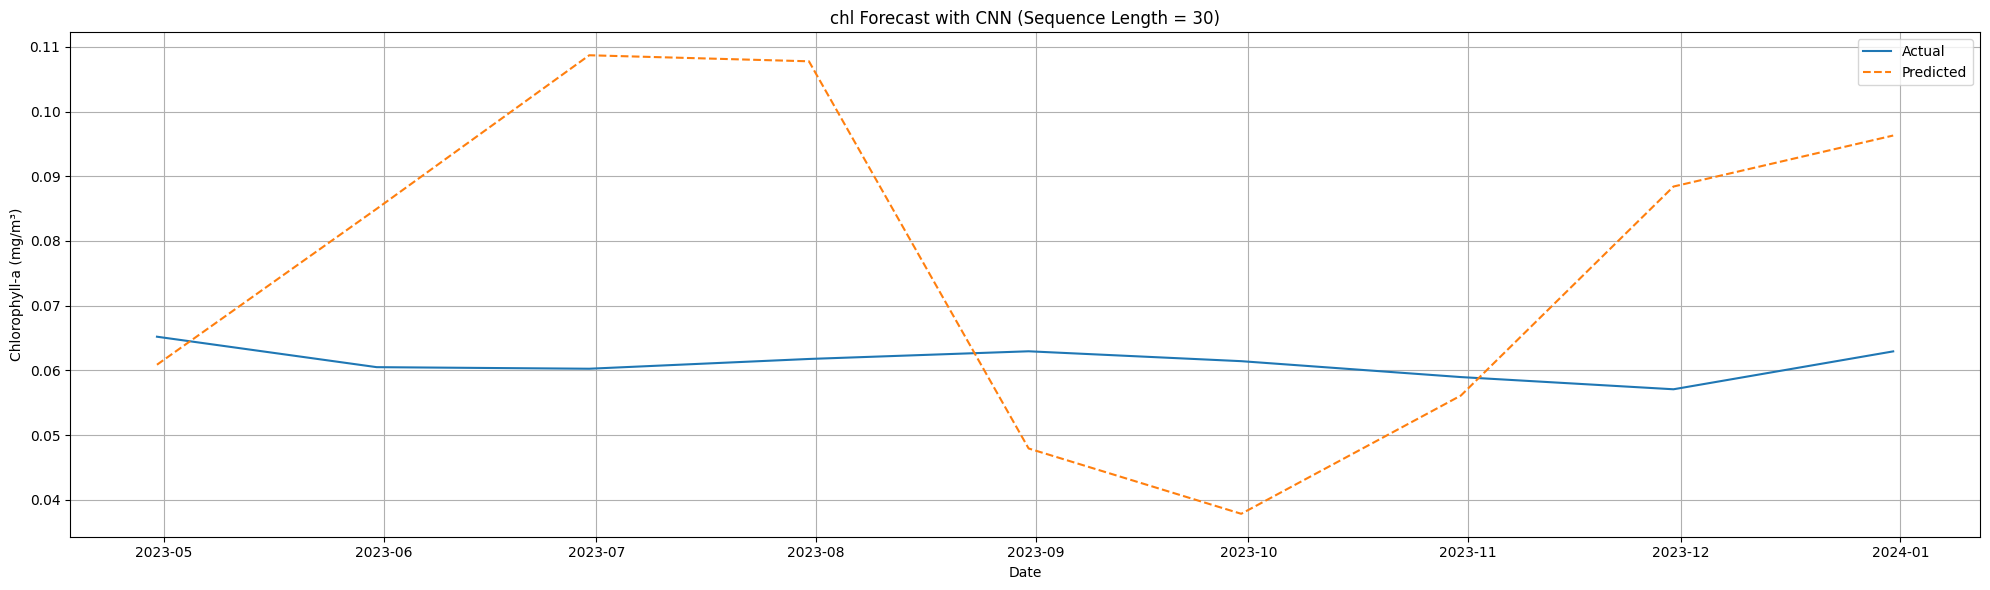

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Sequence Length: 50
CNN Mean Squared Error (MSE): 0.00
CNN Root Mean Squared Error (RMSE): 0.02
CNN Mean Absolute Error (MAE): 0.02
CNN R² (R-Squared): -62.41


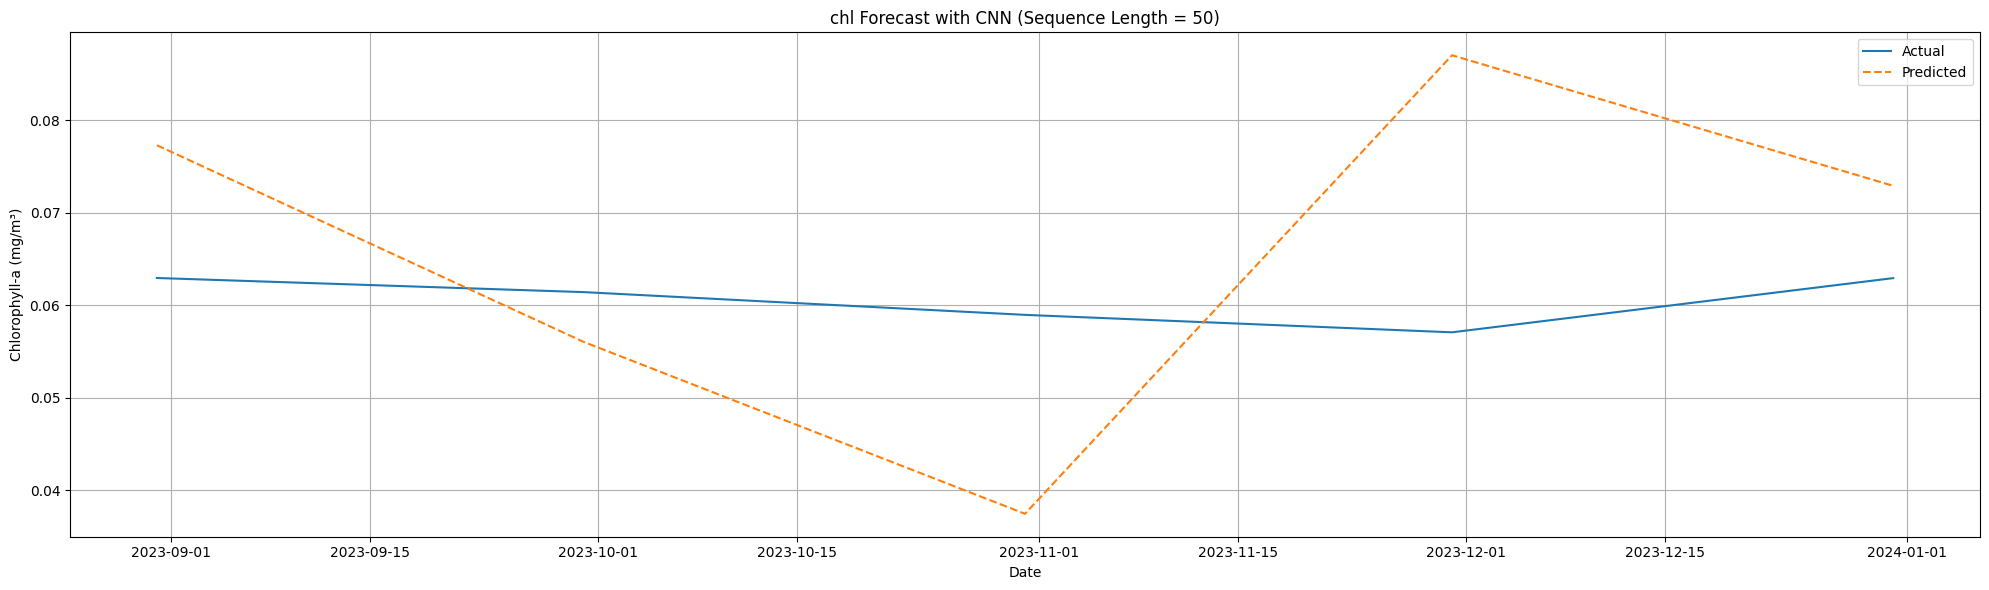

Insufficient data for sequence length 90. Skipping...


In [24]:
# Function to create sequences for the CNN
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df_chl.values.reshape(-1, 1))

# Define sequence lengths
for sequence_length in [10, 20, 30, 50, 90]:
    # Create sequences
    X, y = create_sequences(data_normalized, sequence_length)

    if X.size == 0:
        print(f"Insufficient data for sequence length {sequence_length}. Skipping...")
        continue

    # Reshape X
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split data into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Define the CNN model
    model = Sequential()
    model.add(Input(shape=(sequence_length, 1)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the CNN
    model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0)

    # Make predictions
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Compute metrics
    mse = mean_squared_error(y_test_rescaled, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_rescaled, predicted)
    r2 = r2_score(y_test_rescaled, predicted)

    print(f"\nSequence Length: {sequence_length}")
    print(f"CNN Mean Squared Error (MSE): {mse:.2f}")
    print(f"CNN Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"CNN Mean Absolute Error (MAE): {mae:.2f}")
    print(f"CNN R² (R-Squared): {r2:.2f}")

    total_sequences = len(data_normalized) - sequence_length
    date_index = df_chl.index[sequence_length + train_size:sequence_length + total_sequences]

    # Plot the results with correct date x-axis
    plt.figure(figsize=(20, 6))
    plt.plot(date_index, y_test_rescaled, label='Actual')
    plt.plot(date_index, predicted, label='Predicted', linestyle='--')
    plt.title(f'chl Forecast with CNN (Sequence Length = {sequence_length})')
    plt.xlabel('Date')
    plt.ylabel('Chlorophyll-a (mg/m³)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
